# Process recount2 data
This notebook does the following:

1. Select template experiment


2. Download and process SRA data in recount2
  
  2a. Download SRA data in recount2 as RangedSummarizedExperiment (rse) object for each project id provided. Raw reads were mapped to genes using Rail-RNA, which includes exon-exon splice junctions. RSE contains counts summarized at the **gene level** using the **Gencode v25 (GRCh38.p7, CHR) annotation** as provided by Gencode.
  
  2b. These rse objects return [coverage counts]   (https://www.bioconductor.org/packages/devel/workflows/vignettes/recountWorkflow/inst/doc/recount-workflow.html) as   opposed to read counts and therefore we need to apply [scale_counts](https://rdrr.io/bioc/recount/man/scale_counts.html) to scale by **sample coverage** (average number of reads mapped per nucleotide)
  
  2c. DESeq performs an internal normalization where geometric mean is calculated for each gene across all samples. The counts for a gene in each sample is then divided by this mean. The median of these ratios in a sample is the size factor for that sample. This procedure corrects for **library size** (i.e. sequencing depth = total number of reads sequenced for a given sample) and RNA composition bias. DESeq expects [un-normalized](http://bioconductor.org/packages/devel/bioc/vignettes/DESeq2/inst/doc/DESeq2.html#input-data) data.


3. Train VAE on recount2 data

In [1]:
%load_ext autoreload
%load_ext rpy2.ipython
%autoreload 2

import os
import sys
import pandas as pd
import numpy as np
import rpy2
import pickle

from ponyo import utils, train_vae_modules
from generic_expression_patterns_modules import process

np.random.seed(123)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
Using TensorFlow backend.


In [2]:
# Read in config variables
base_dir = os.path.abspath(os.path.join(os.getcwd(),"../"))

config_file = os.path.abspath(
    os.path.join(base_dir, "configs", "config_human.tsv")
)
params = utils.read_config(config_file)

### Set parameters for data processing

Most parameters are read from `config_file`. We manually selected bioproject [SRP012656](https://www.ncbi.nlm.nih.gov/geo/query/acc.cgi?acc=GSE37764) as the template experiment, which contains primary non-small cell lung adenocarcinoma tumors and adjacent normal tissues of 6 never-smoker Korean female patients with 2 replicates each.

In [3]:
# Load params from config_file
local_dir = params["local_dir"]
dataset_name = params['dataset_name']
NN_architecture = params['NN_architecture']
raw_template_filename = params['raw_template_filename']
mapped_template_filename = params['mapped_template_filename']
processed_template_filename = params['processed_template_filename']
raw_compendium_filename = params['raw_compendium_filename']
mapped_compendium_filename = params['mapped_compendium_filename']
normalized_compendium_filename = params['normalized_compendium_filename']
shared_genes_file = params['shared_genes_file']
scaler_file = params['scaler_transform_file']

# File that contains generic genes identified by Crow et. al.
DE_prior_file = params['reference_gene_file']

# Template experiment ID
project_id = params['project_id']

### Download template experiment's expression data

In [7]:
# Directory where the downloaded files of template experiment will be saved into
template_download_dir = os.path.join(local_dir, "template_download")
# Make sure this directory already exists
os.makedirs(template_download_dir, exist_ok=True)

%%R -i project_id -i template_download_dir -i raw_template_filename

source('../generic_expression_patterns_modules/download_recount2_data.R')

get_recount2_template_experiment(project_id, local_dir)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 18:03:24 downloading file rse_gene.Rdata to SRP012656

  warnings.warn(x, RRuntimeWarning)


Loading objects:
  rse_gene


### Download all recount2 data and compile them together as a compendium

In [6]:
# Directory where the recount2 SRA data files are saved into
compendium_download_dir = os.path.join(local_dir, "compendium_download")
# Make sure this directory already exists
os.makedirs(compendium_download_dir, exist_ok=True)

metadata_dir = local_dir

%%R -i metadata_dir -i compendium_download_dir

source('../generic_expression_patterns_modules/download_recount2_data.R')

download_recount2_sra(metadata_dir, compendium_download_dir)

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:55:30 downloading the metadata to /tmp/Rtmp2F2kiO/metadata_clean_sra.Rdata

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'https://github.com/leekgroup/recount-website/blob/master/metadata/metadata_clean_sra.Rdata?raw=true'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: Content type 'application/octet-stream'
  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2531337 bytes (2.4 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 2.3 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:55:50 downloading file rse_gene.Rdata to SRP045269

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP045269/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1963724 bytes (1.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 1.9 MB


  war

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:56:04 downloading file rse_gene.Rdata to SRP010041

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP010041/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2394059 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:56:05 downloading file rse_gene.Rdata to SRP038143

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:56:18 downloading file rse_gene.Rdata to SRP056041

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP056041/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3940504 bytes (3.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 3.8 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:56:19 downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 4.7 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:56:33 downloading file rse_gene.Rdata to SRP034606

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP034606/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 3305004 bytes (3.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 3.2 MB


  war

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:56:52 downloading file rse_gene.Rdata to SRP002621

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP002621/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2692623 bytes (2.6 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:56:53 downloading file rse_gene.Rdata to SRP045911

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:57:10 downloading file rse_gene.Rdata to SRP007481

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP007481/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1892560 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:57:11 downloading file rse_gene.Rdata to SRP051000

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:57:27 downloading file rse_gene.Rdata to SRP014428

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP014428/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 9794038 bytes (9.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 9.3 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:57:29 downl

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 4.0 MB


  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:57:49 downloading file rse_gene.Rdata to ERP003933

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP003933/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 5178540 bytes (4.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: downloaded 4.9 MB


  war

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:58:06 downloading file rse_gene.Rdata to SRP050074

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP050074/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1916977 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:58:08 downloading file rse_gene.Rdata to SRP064820

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:58:26 downloading file rse_gene.Rdata to ERP003815

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP003815/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1967564 bytes (1.9 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:58:27 downloading file rse_gene.Rdata to SRP057613

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:58:49 downloading file rse_gene.Rdata to SRP018779

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP018779/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2442116 bytes (2.3 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:58:51 downloading file rse_gene.Rdata to SRP009276

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:59:11 downloading file rse_gene.Rdata to SRP064457

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP064457/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2262483 bytes (2.2 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:59:12 downloading file rse_gene.Rdata to SRP032165

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:59:34 downloading file rse_gene.Rdata to ERP010136

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/ERP010136/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1918542 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:59:35 downloading file rse_gene.Rdata to SRP013389

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 17:59:58 downloading file rse_gene.Rdata to SRP035679

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP035679/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 1856693 bytes (1.8 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 18:00:00 downloading file rse_gene.Rdata to ERP000992

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 18:00:19 downloading file rse_gene.Rdata to SRP001558

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP001558/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2612948 bytes (2.5 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 18:00:20 downloading file rse_gene.Rdata to SRP060715

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 18:00:42 downloading file rse_gene.Rdata to SRP039552

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: trying URL 'http://duffel.rail.bio/recount/v2/SRP039552/rse_gene.Rdata'

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning:  length 2139749 bytes (2.0 MB)

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:146: RRuntimeWarning: 2020-08-10 18:00:44 downloading file rse_gene.Rdata to SRP032953

  warnings.warn(x, RRuntimeWarning)
/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/rpy2/rinterface/__init__.py:1

[1] "SRP012651"
Loading objects:
  rse_gene
[1] "SRP014574"
Loading objects:
  rse_gene
[1] "SRP000542"
Loading objects:
  rse_gene
[1] "SRP016059"
Loading objects:
  rse_gene
[1] "SRP001540"
Loading objects:
  rse_gene
[1] "SRP034626"
Loading objects:
  rse_gene
[1] "SRP062873"
Loading objects:
  rse_gene
[1] "SRP041956"
Loading objects:
  rse_gene
[1] "SRP046254"
Loading objects:
  rse_gene
[1] "SRP044956"
Loading objects:
  rse_gene
[1] "SRP045269"
Loading objects:
  rse_gene
[1] "SRP039357"
Loading objects:
  rse_gene
[1] "SRP049238"
Loading objects:
  rse_gene
[1] "SRP021130"
Loading objects:
  rse_gene
[1] "SRP018571"
Loading objects:
  rse_gene
[1] "SRP056201"
Loading objects:
  rse_gene
[1] "SRP060708"
Loading objects:
  rse_gene
[1] "SRP023262"
Loading objects:
  rse_gene
[1] "SRP037775"
Loading objects:
  rse_gene
[1] "SRP041531"
Loading objects:
  rse_gene
[1] "SRP034953"
Loading objects:
  rse_gene
[1] "SRP010041"
Loading objects:
  rse_gene
[1] "SRP038143"
Loading objects:

### Create raw recount2 compendium file
The single raw compendium file is compiled from the individual projects that we downloaded and processed. 

In [ ]:
process.create_recount2_compendium(compendium_download_dir, raw_compendium_filename)

### Subset genes and convert gene names
For our downstream analysis, we will be comparing our set of differentially expression genes against the set found in [Crow et. al. publication](https://www.pnas.org/content/pnas/116/13/6491.full.pdf), therefore we will limit our genes to include only those genes shared between our starting set of genes and those in publication. 

In [11]:
# File mapping ensembl ids to hgnc symbols
gene_id_filename = os.path.join(local_dir,"ensembl_hgnc_mapping.tsv")

In [12]:
%%R
suppressWarnings(library("biomaRt"))

In [13]:
%%R -i raw_template_filename -i gene_id_filename

# Get mapping between ensembl gene ids (ours) to HGNC gene symbols (published)

source('../generic_expression_patterns_modules/process_names.R')

if (file.exists(gene_id_file) == FALSE){
    gene_id_mapping <- get_ensembl_symbol_mapping(raw_template_filename, gene_id_filename)
}

### Process recount2 template experiment data
This step will map the ensembl gene IDs in raw template data file to hgnc gene symbols, and delete certain columns (genes) and rows (samples). Two output files will be generated in this step: `mapped_template_filename` and `processed_template_filename`.

In [21]:
manual_mapping = {                                                                                  
    "ENSG00000187510.7": "PLEKHG7",       
    "ENSG00000230417.11": "LINC00595",                      
    "ENSG00000276085.1": "CCL3L1",                     
    "ENSG00000255374.3": "TAS2R45",                       
}

# metadata file with grouping assignments for samples
sample_id_metadata_file = os.path.join(
    base_dir,
    dataset_name,
    "data",
    "metadata",
    f"{project_id}_process_samples.tsv"
)

process.process_raw_template(
    raw_template_filename,
    gene_id_filename,
    manual_mapping
    DE_prior_filename,
    mapped_template_filename,
    sample_id_metadata_filename,
    processed_template_filename
)

### Map ensembl gene IDs in raw compendium file and normalize it
The mapping process in this step is similar to the one when processing template data. Two output files will be generated in this step too: `mapped_compendium_filename` and `normalized_compendium_filename`.

In [30]:
process.process_raw_compendium(
    raw_compendium_filename,
    gene_id_filename,
    manual_mapping,
    DE_prior_filename,
    mapped_compendium_filename,
    normalized_compendium_filename
)

### Train VAE 
Performed exploratory analysis of compendium data [here](../explore_data/viz_recount2_compendium.ipynb) to help interpret loss curve.

In [31]:
# Setup directories
# Create VAE directories
output_dirs = [
    os.path.join(base_dir, dataset_name, "models"),
    os.path.join(base_dir, dataset_name, "logs")
]

# Check if NN architecture directory exist otherwise create
for each_dir in output_dirs:
    new_dir = os.path.join(each_dir, NN_architecture)
    os.makedirs(new_dir, exist_ok=True)

input dataset contains 3388 samples and 17788 genes
Instructions for updating:
Colocations handled automatically by placer.
tracking <tf.Variable 'Variable:0' shape=() dtype=float32> beta
Instructions for updating:
Use tf.cast instead.


/home/alexandra/anaconda3/envs/generic_expression/lib/python3.7/site-packages/keras/engine/training_utils.py:819: UserWarning: Output custom_variational_layer_1 missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to custom_variational_layer_1.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 2541 samples, validate on 847 samples
Epoch 1/40
2541/2541 [==============================] - 330s 130ms/step - loss: 3221.1959 - val_loss: 3007.9072
Epoch 2/40
2541/2541 [==============================] - 330s 130ms/step - loss: 2943.6953 - val_loss: 2961.9811
Epoch 3/40
2541/2541 [==============================] - 333s 131ms/step - loss: 2913.2871 - val_loss: 2925.5691
Epoch 4/40
2541/2541 [==============================] - 333s 131ms/step - loss: 2882.9977 - val_loss: 2919.8791
Epoch 5/40
2541/2541 [==============================] - 335s 132ms/step - loss: 2861.8532 - val_loss: 2890.8733
Epoch 6/40
2541/2541 [==============================] - 335s 132ms/step - loss: 2850.5113 - val_loss: 2872.4591
Epoch 7/40
2541/2541 [==============================] - 335s 132ms/step - loss: 2827.7885 - val_loss: 2856.9468
Epoch 8/40
2541/2541 [==============================] - 336s 132ms/step - loss: 2812.2756 - val_loss: 2844.2768
Epoch 9/40
2541/2541 [==============================] - 3

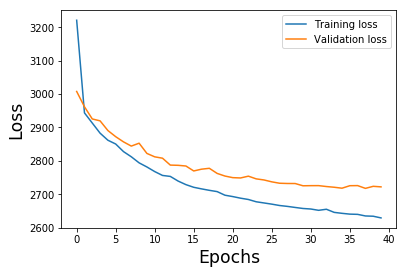

In [32]:
# Train VAE on new compendium data
train_vae_modules.train_vae(config_file, normalized_compendium_filename)